In [13]:
# 필요한 기본 패키지 준비

# 데이터 처리 필요 패키지
import numpy as np
import pandas as pd
import datetime as dt
import math

# 시각화 필요 패키지
%matplotlib inline
from plotnine import *
import folium
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import seaborn as sns


# Machine Learning 분석 환경 준비

# 전처리, 스케일링
from sklearn.preprocessing import StandardScaler

# 선형회귀분석
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# OLS회귀분석
import statsmodels.api as sm

# GAM 일반화가법모형
# LinearGAM, LogisticGAM, PoissonGAM, GammaGAM, InvGuss
from pygam import LinearGAM, LogisticGAM, PoissonGAM, GammaGAM

# Boosting

#데이터셋 분리
from sklearn.model_selection import train_test_split



# 한글 처리
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# jupyter notebook에서 warning 무시하기
import warnings
warnings.filterwarnings("ignore")

In [19]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1))
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


In [20]:
#########################################################################
# 날씨중 rain 데이터 카테고리 화 : 0mm -> 0(맑음) , 0mm 이상 ->1(비옴), 30mm 이상 ->2(비많이 옴)
def rainCat(mm):
    if mm == 0:
        return 0
    if mm >= 30:
        return 2
    if mm > 0:
        return 1

#########################################################################
# 날씨중 snow 데이터 카테고리 화 : 0mm -> 0(맑음) , 0mm 이상 ->1(눈옴), 30mm 이상 ->2눈 많이 옴)
def snowCat(mm):
    if mm == 0:
        return 0
    if mm >= 30:
        return 2
    if mm > 0:
        return 1
#########################################################################
# 날씨중 temp 데이터 카테고리 화 : -10이하 :0, 0이하 :1, 10도이하:2, 20도 이하: 3, 30도이하:4, 30도 초과 :5
def tempCat(temp):
    if temp >= 30.0:
        return 5
    if temp <= -10.0:
        return 0
    if (temp <30.0) & (temp>=20.0):
        return 4
    if (temp <20.0) & (temp >=10.0):
        return 3
    if (temp <10.0) & (temp >=0.0):
        return 2
    if (temp <0.0)  & (temp >= -10.0):
        return 1

#########################################################################
# 미세먼지 농도를 활용해서 0,1,2,3(좋음, 보통, 나쁨, 매우나쁨) 카테고리 생성

# 서울시청 미세먼지 농도 기준
# https://bluesky.seoul.go.kr/finedust/common-sense/page/10?article=745

# ppm
# O3   |0~0.03|0.031~0.09|0.091~0.15|0.151~
def o3Cat(o3):
    if (o3<=0.03):
        return 0
    if (o3>0.03) & (o3<=0.09):
        return 1
    if (o3>0.09) & (o3<=0.15):
        return 2
    if (o3>0.15):
        return 3


# NO2  |0~0.03|0.031~0.06|0.061~0.2|0.201~
def no2Cat(no2):
    if (no2<=0.03):
        return 0
    if (no2>0.03) & (no2<=0.06):
        return 1
    if (no2>0.06) & (no2<=0.2):
        return 2
    if (no2>0.2):
        return 3

# CO     |0~2|2.01~9|9.01~15|15.01~
def coCat(co):
    if (co<=2):
        return 0
    if (co>2) & (co<=9):
        return 1
    if (co>9) & (co<=15):
        return 2
    if (co>15):
        return 3

# SO2    |0~0.02|0.021~0.05|0.051~0.15|0.151~
def s02Cat(so2):
    if (so2<=0.02):
        return 0
    if (so2>0.02) & (so2<=0.05):
        return 1
    if (so2>0.05) & (so2<=0.15):
        return 2
    if (so2>0.151):
        return 3


# (일평균,㎍/㎥)	예보 등급(일평균, ㎍/㎥)
# 			좋음		보통	나쁨	매우나쁨
# PM-2.5	0~15	16~35	36~75	76~
def ulFineD(pm25):
    if (pm25 >= 76):
        return 3
    if (pm25 >=36) & (pm25<76):
        return 2
    if (pm25 >=16) & (pm25<36):
        return 1
    if (pm25 >=0) & (pm25<16):
        return 0

# PM-10		0~30	31~80	81~100	151~
def fineD(pm10):
    if (pm10 >= 151):
        return 3
    if (pm10 >=80) & (pm10<100):
        return 2
    if (pm10 >=30) & (pm10<80):
        return 1
    if (pm10 >=0) & (pm10<30):
        return 0

In [4]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

In [21]:
# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

# 컬럼 이름을 변경하여 Series로 돌려주는 함수
sns_all.columns = changeColNames(sns_all,'.','_')
# ols formula입력시 오류 발생 방지를위해 컬럼명 문자열 내, 마침표(.)가 전부 underscore(_)로 변경
# sns_all.columns

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']
lv_grouped = lv_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()
# lv_grouped.tail(2)

랄라블라
1. 선케어
2. 바디로션
3. 제모제

GS
1. 마스크
2. 맥주
3. 아이스크림

# 선케어

## 일단위 자료
#### 함수를 만들기전, 함수에 들어갈 코딩을 위한 사전 작업

In [22]:
w_day = w_seoul[[ 'date', 'temp', 'rain', 'cloud', 'wind', 'humid', 'hpa',
       'sun_time', 'lgt_time', 'snow', 'uv', 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25']]
w_day = addDayWeek(w_day)
w_day.head(8)

,date,temp,rain,cloud,wind,humid,hpa,sun_time,lgt_time,snow,uv,SO2,CO,O3,NO2,PM10,PM25,day,week
0,2016-01-01,1.2,0.0,7.0,1.6,73.0,1019.9,9.6,2.1,0.0,NaN,0.005993,0.988250,0.005362,0.048646,68.696500,42.954273,1,1
1,2016-01-02,5.7,0.0,7.8,2.0,76.9,1012.0,9.6,3.6,0.0,NaN,0.005959,0.740500,0.008833,0.045624,53.618667,31.265302,2,1
2,2016-01-03,6.5,0.0,7.5,1.8,80.6,1008.9,9.7,2.2,0.0,NaN,0.007285,0.973215,0.012414,0.051033,97.820652,56.889171,3,1
3,2016-01-04,2.0,0.0,4.4,3.1,54.4,1013.1,9.7,8.6,0.0,NaN,0.006177,0.643143,0.023534,0.028781,79.011348,46.221245,4,1
4,2016-01-05,-2.7,0.0,3.4,2.3,39.4,1016.9,9.7,7.9,0.0,NaN,0.005999,0.466950,0.015341,0.028488,33.830886,16.792139,5,1
5,2016-01-06,-1.7,0.0,6.0,1.8,54.3,1014.7,9.7,2.2,0.0,NaN,0.007054,0.713674,0.007102,0.043356,57.411239,29.384742,6,1
6,2016-01-07,-3.4,0.0,0.3,2.5,51.8,1013.9,9.7,9.1,0.0,NaN,0.006163,0.551312,0.014928,0.029837,41.477252,20.742607,7,1
7,2016-01-08,-3.3,0.0,0.5,2.0,49.8,1012.6,9.7,9.2,0.0,NaN,0.006381,0.570863,0.012989,0.034100,36.618715,18.207585,8,2


In [5]:
# 서울특별시 단위로 df조정(구단위 데이터 합치기)
day_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()
# day_lv_grouped.tail(3)

# '선케어'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'day_gs_grouped_w_item'생성
item = '선케어'
day_lv_grouped_w_item = pd.merge(day_lv_grouped.loc[day_lv_grouped.category==item],w_seoul,on='date',how='left')
day_lv_grouped_w_sns_item = pd.merge(day_lv_grouped_w_item, sns_all,on='date',how='left')

# ind_vars = ['temp','humid','wind','sun_time']
# ind_vars = ['temp','humid','wind','rain','snow','cloud','sun_time']
# ind_vars = ['temp','humid','wind','rain','snow','cloud','sun_time'
#                 ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']

ind_vars = ['temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']

linReg(day_lv_grouped_w_sns_item,item,ind_vars)
ridgeReg(day_lv_grouped_w_sns_item,item,ind_vars)
lassoReg(day_lv_grouped_w_sns_item,item,ind_vars)

Xy = day_lv_grouped_w_sns_item.loc[day_lv_grouped_w_sns_item['category']==item,ind_vars+['qty']]
model = sm.OLS.from_formula("qty ~ temp + sun_time + cloud + health_total + date_total", data=Xy)
# model = sm.OLS.from_formula("qty ~ temp + humid + sun_time + rain", data=Xy)
# model = sm.OLS.from_formula("qty ~ temp", data=Xy)

print(model.fit().summary())

LinearRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.43
검증세트점수 : 0.46
RidgeRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.42
검증세트점수 : 0.46
LassoRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.43
검증세트점수 : 0.46
사용한 특성수 : 12
                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     160.4
Date:                Thu, 11 Jul 2019   Prob (F-statistic):          8.30e-128
Time:                        15:23:50   Log-Likelihood:                -10443.
No. Observations:                1096   AIC:                         2.090e+04
Df Residuals:                    1090   BIC:                         2.093e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
    

## 주단위 자료 생성

### 선케어만
#### 자료생성 파트

In [6]:
cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# '선케어'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'week_gs_grouped'생성
item = '선케어'
week_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()
# week_lv_grouped.tail(2)
week_lv_grouped_gu =week_lv_grouped.loc[week_lv_grouped.category==item]
# week_lv_grouped_gu.tail(3)

# '마스크'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'week_gs_grouped'생성
week_lv_grouped_item = week_lv_grouped.loc[week_lv_grouped.category==item].reset_index()
# 이제 'week_lv_grouped_item'에 한 날짜에 한 item(선케어)만 들어가있는 df가 됨.

week_lv_grouped_w_item = pd.merge(week_lv_grouped,w,on='date',how='left')
week_lv_grouped_w_item_sns = pd.merge(week_lv_grouped_w_item,sns_all,on='date',how='left')
# week_lv_grouped_w_item_sns.tail(2)


week_w = addDayWeek(w_seoul)
week_w = week_w.groupby('week').mean().reset_index()
week_w.drop(columns=['loc','day','year','month','weekday','nth_week'], inplace=True)
# week_w.tail(2)

# sns자료는 2019년 4월달 자료 까지 있다.
week_sns = addDayWeek(sns_all.loc[sns_all.date.between('2016-01-01','2018-12-31', inclusive=True)])
# week_sns = week_sns.groupby('week').sum().reset_index()
week_sns = week_sns.groupby('week').mean().reset_index()
# week_sns.tail(2)

check = addDayWeek(week_lv_grouped_item)
check.drop(columns='index',inplace=True)
# check = check[['week','category','qty']].groupby(by=['week','category']).sum().reset_index()
check = check[['week','category','qty']].groupby(by=['week','category']).mean().reset_index()
# check.tail()
check_merged = mergeForAnalysis(check, week_w, week_sns, item, on_what='week')
# check_merged.columns

#### 예측모델 파트

In [12]:
ind_vars = ['temp','humid','wind','rain','snow','cloud','sun_time'
             ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']

linReg(check_merged,item,ind_vars)
ridgeReg(check_merged,item,ind_vars)
lassoReg(check_merged,item,ind_vars)
print('')
# ols모델
Xy = check_merged.loc[check_merged['category']==item, ind_vars+['qty']]

model = sm.OLS.from_formula(
    "qty ~ I(temp**2) "
    , data=Xy)
# model = sm.OLS.from_formula("qty ~ temp + pm_total + health_total ", data=Xy)

print(model.fit().summary())

LinearRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.63
검증세트점수 : 0.51
RidgeRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.61
검증세트점수 : 0.49
LassoRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.63
검증세트점수 : 0.51
사용한 특성수 : 12

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     82.78
Date:                Thu, 11 Jul 2019   Prob (F-statistic):           4.23e-16
Time:                        15:26:40   Log-Likelihood:                -1482.6
No. Observations:                 157   AIC:                             2969.
Df Residuals:                     155   BIC:                             2975.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
   

# uv데이터를 사용해서 예측진행
## uv 데이터 사용전 데이터 처리

In [35]:
cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# '선케어'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'week_gs_grouped'생성
item = '선케어'
week_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()
# week_lv_grouped.tail(2)
week_lv_grouped_gu =week_lv_grouped.loc[week_lv_grouped.category==item]
# week_lv_grouped_gu.tail(3)

# '마스크'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'week_gs_grouped'생성
week_lv_grouped_item = week_lv_grouped.loc[week_lv_grouped.category==item].reset_index()
# 이제 'week_lv_grouped_item'에 한 날짜에 한 item(선케어)만 들어가있는 df가 됨.

week_lv_grouped_w_item = pd.merge(week_lv_grouped,w,on='date',how='left')
week_lv_grouped_w_item_sns = pd.merge(week_lv_grouped_w_item,sns_all,on='date',how='left')
# week_lv_grouped_w_item_sns.tail(2)


week_w = addDayWeek(w_seoul)
week_w = week_w.groupby('week').mean().reset_index()
week_w.drop(columns=['loc','day','year','month','weekday','nth_week'], inplace=True)
# week_w.tail(2)

# sns자료는 2019년 4월달 자료 까지 있다.
week_sns = addDayWeek(sns_all.loc[sns_all.date.between('2016-01-01','2018-12-31', inclusive=True)])
# week_sns = week_sns.groupby('week').sum().reset_index()
week_sns = week_sns.groupby('week').mean().reset_index()
# week_sns.tail(2)

check = addDayWeek(week_lv_grouped_item)
check.drop(columns='index',inplace=True)
# check = check[['week','category','qty']].groupby(by=['week','category']).sum().reset_index()
check = check[['week','category','qty']].groupby(by=['week','category']).mean().reset_index()
# check.tail()
check_merged = mergeForAnalysis(check, week_w, week_sns, item, on_what='week')
# check_merged.columns

In [41]:
# uv데이터는 결측치가 많다.
print('UV 데이터 포함(결측치가 있는 주는 제거)\n')
check_merged = check_merged.loc[check_merged.uv.notnull()]
ind_vars = ['temp','humid','wind','rain','snow','cloud','sun_time', 'uv'
             ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']

linReg(check_merged,item,ind_vars)
ridgeReg(check_merged,item,ind_vars)
lassoReg(check_merged,item,ind_vars)
print('')
# ols모델
Xy = check_merged.loc[check_merged['category']==item, ind_vars+['qty']]

model = sm.OLS.from_formula(
    "qty ~ sun_time + uv + cloud + rain"
    , data=Xy)
# model = sm.OLS.from_formula("qty ~ temp + pm_total + health_total ", data=Xy)

print(model.fit().summary())

UV 데이터 포함(결측치가 있는 주는 제거)

LinearRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.60
검증세트점수 : 0.55
RidgeRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.57
검증세트점수 : 0.68
LassoRegression을 이용한 선케어의 회귀분석 결과 :
훈련세트점수 : 0.60
검증세트점수 : 0.55
사용한 특성수 : 13

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     35.70
Date:                Thu, 11 Jul 2019   Prob (F-statistic):           1.66e-18
Time:                        15:37:20   Log-Likelihood:                -967.75
No. Observations:                 105   AIC:                             1946.
Df Residuals:                     100   BIC:                             1959.
Df Model:                           4                                         
Covariance Type:            nonrobust                   

<function matplotlib.pyplot.show(*args, **kw)>

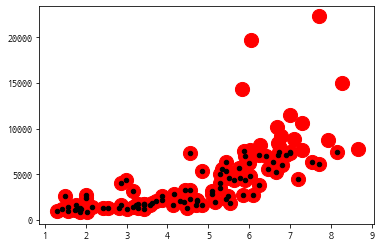

In [53]:
plt.scatter(Xy['uv'],Xy['qty'], c='r',s=200)

Xy_no_outlier = Xy.copy()
Xy_no_outlier['outlier'] = mad_based_outlier(Xy_no_outlier['qty'],thresh=1.5)
Xy_no_outlier = Xy_no_outlier.loc[Xy_no_outlier.outlier==False]
#Xy_no_outlier = Xy.loc[Xy.qty<12_000]

plt.scatter(Xy_no_outlier['uv'],Xy_no_outlier['qty'], c='k',s=20)
plt.show

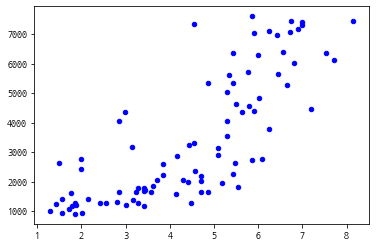

In [51]:
plt.scatter(Xy_no_outlier['uv'],Xy_no_outlier['qty'], c='b',s=20)

In [23]:
model = sm.OLS.from_formula(
    "qty ~ I(uv**2)"
    , data=Xy_no_outlier)


# model = sm.OLS.from_formula("qty ~ temp + uv + pm_total + health_total ", data=Xy)
ols_model = model.fit()

print(ols_model.summary())

NameError: name 'Xy_no_outlier' is not defined

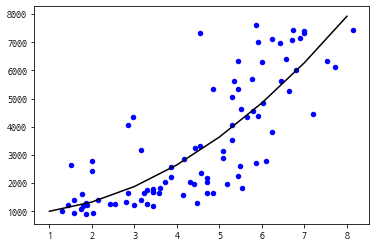

In [78]:
c1 = 109.8961
intercept = 889.3919
plt.scatter(Xy_no_outlier['uv'],Xy_no_outlier['qty'], c='b',s=20)
uv_list = pd.Series(list(range(int(Xy_no_outlier.uv.min()),int(Xy_no_outlier.uv.max())+1)))
plt.plot(uv_list, intercept + c1*(uv_list ** 2), c='k')
plt.show()

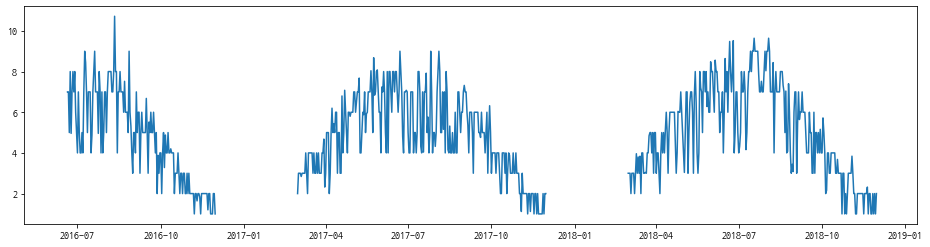

In [28]:
# 일단위 3년간의 평균 uv지수 변화
w_day_temp = w[['date','uv']]
w_day_temp['day'] = pd.Series(range(1,w_day_temp.shape[0]+1))
w_day_temp['week'] = w_day_temp['day'].apply(lambda x : x//7)
plt.figure(figsize=(16,4))
plt.plot(w_day_temp['date'],w_day_temp['uv'])

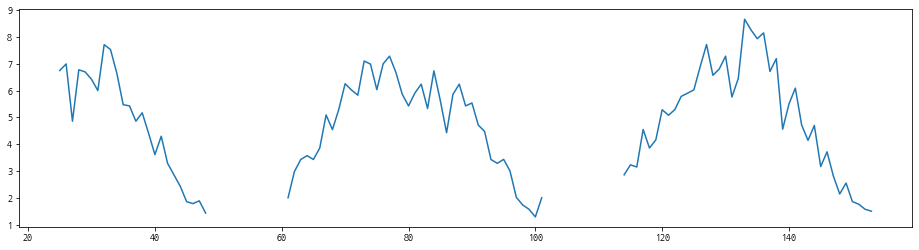

In [30]:
# 주단위 3년간의 평균 uv지수 변화
w_week_temp = week_w[['week','uv']]
plt.figure(figsize=(16,4))
plt.plot(w_week_temp['week'],w_week_temp['uv'])